In [2]:
import tensorflow as tf
import numpy as np
import os
import re
import tensorflow_hub as hub
import pandas as pd
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

### Get Data

In [3]:
data = pd.read_csv('dataset/data/ner_articles_dataset.csv')

In [4]:
data.head()

,Unnamed: 0,title,content,link,source,class,modified_content
0,0,Tibit Communications Raises $20M in Series B F...,"Tibit Communications, Inc., a Petaluma, CA-bas...",http://www.finsmes.com/2019/04/tibit-communica...,FinsmesUSA,Funding,"organization, a Petaluma, organization-based s..."
1,1,Twitter blames human error after blocking a Ne...,"Over the holiday weekend, The New York Times f...",https://techcrunch.com/2017/11/27/twitter-blam...,techcrunch,Other,"Over the holiday weekend, organization found t..."
2,2,SimplyCook Raises £4.5M in Series A Funding\n,"SimplyCook, a London, UK-based recipe kit serv...",http://www.finsmes.com/2019/01/simplycook-rais...,FinsmesUK,Funding,"organization, a London, UK-based recipe kit se..."
3,3,Moogsoft Secures $40M in Series D Funding\n,"Moogsoft, a San Francisco, CA-based provider o...",http://www.finsmes.com/2018/03/moogsoft-secure...,FinsmesUSA,Funding,"organization, a San Francisco, organization-ba..."
4,4,Zeta Global acquires commenting service†Disqus,A source close to the two companies tells us t...,https://techcrunch.com/2017/12/05/zeta-global-...,techcrunch,Other,A source close to the two companies tells us t...


In [6]:
data.loc[4, 'modified_content']

'A source close to the two companies tells us that the acquisition price was money. This marks organization’s eleventh acquisition since it was founded in 2007. organization Global’s acquisitions have typically focused on more fundamental technologies like AI and machine learning, customer lifecycle management and other adtech related services. At first glance, organization doesn’t quite seem to fit into this list, but organization sits on a huge data set that goes beyond your favorite troll’s political comments. “Marketers typically have to make trade-offs between reaching engaged audiences on social platforms with massive reach and using tools that give them control and access to granular targeting capabilities,” said organization Global CEO, chairman and co-founder person. “organization strengthens organization’s ability to offer the best of both worlds with the scale, visibility and performance marketers have been asking for.” organization gives these marketers the ability to targe

In [7]:
def preprocess_content(content):
    content = content.lower()
    links_regex = re.compile('(https?:\/\/|www|ftp)[\w\./\?\=+&-]+')
    money_regex = re.compile('USD\s?\d+[,\d]+|\$\s?\d+[,\d]+|GBP\s?\d+[,\d]+|£\s?\d+[,\d]+|EUR\s?\d+[,\d]+|€\s?\d+[,\d]+', flags=re.IGNORECASE)
    digits_regex = re.compile('\d+[,.\d]+')
    white_space_regex = re.compile('\s+')
    
    content = re.sub(links_regex, 'LINK',  content)
    content = re.sub(money_regex, 'MONEY', content)
    content = re.sub(digits_regex, 'NUMBER', content)
    content = re.sub(white_space_regex, ' ', content)
    
    return content

In [8]:
data = data[~data['content'].isnull()]

In [9]:
data['class'].value_counts()

Other      22868
Funding    21163
Name: class, dtype: int64

In [10]:
data['modified_content'] = data['modified_content'].map(preprocess_content)

In [11]:
articles = data['modified_content'].values
titles = data['title'].values
labels = data['class'].values

#### Encode labels

In [12]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


def encode_labels(labels):
    encoded = label_encoder.transform(labels)
    return encoded

def decode_labels(encoded_labels):
    labels_type = type(encoded_labels)
    
    if labels_type == int:
        try:
            label = label_encoder.inverse_transform([encoded_labels])
        except ValueError:
            print('Unknown value')
            return np.nan
        
        return label
    
    elif hasattr(encoded_labels, '__iter__') and labels_type != str:
        try:
            labels = label_encoder.inverse_transform(encoded_labels)
            
        except ValueError:
            print('Unknown value')
            raise
            
        return labels
    else:
        raise TypeError

In [13]:
tf.test.is_gpu_available()

True

### Use TensorFlow Keras and CNN

In [14]:
shuffle = np.random.permutation(len(articles))
articles = articles[shuffle]
titles = titles[shuffle]
labels = labels[shuffle]

In [15]:
len(articles)

44031

In [16]:
data_size = len(articles)

train_size = round(0.8 * data_size)
dev_size = round(0.1 * data_size)

dev_end = train_size + dev_size

print(train_size, dev_size, dev_end)

35225 4403 39628


In [17]:
articles_train, labels_train, titles_train = articles[:train_size], labels[:train_size], titles[:train_size]
articles_dev, labels_dev, titles_dev = articles[train_size:dev_end], labels[train_size:dev_end], titles[train_size:dev_end]
articles_test, labels_test, titles_test = articles[dev_end:], labels[dev_end:], titles[dev_end:]

### Preprocess the text for use with the CNN

In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(articles_train)

X_train = tokenizer.texts_to_sequences(articles_train)
X_dev = tokenizer.texts_to_sequences(articles_dev)
X_test = tokenizer.texts_to_sequences(articles_test)

vocab_size = len(tokenizer.word_index) + 1

vocab_size

95584

In [19]:
maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Run CNN models 

#### Function to plot the history of models

In [20]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

#### Function to Build Model

In [21]:
epochs = 20
embedding_dim = 100
num_filters = 128
kernel_sizes = [2, 3, 5]
dense_layer_dims = [20,30,10]
dropout_rate = 0.1

def build_cnn_model(kernel_sizes, dense_layer_dims, vocab_size, embedding_dim=50, embedding_matrix=None, trainable=False, max_len=300, dropout_rate=0.1, num_filters=128):
    wordids = layers.Input(shape=(max_len, ))
    
    if type(embedding_matrix) == np.ndarray:
        emb = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=trainable)(wordids)
    else:
        emb = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, trainable=trainable)(wordids)
    
    conv_layers_list = []
    
    for kernel_size in kernel_sizes:
        conv_layer = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(emb)
        conv_layer = layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_list.append(conv_layer)
        
    concat_layer = layers.concatenate(conv_layers_list, axis=1)
    dense_layer = layers.Dropout(rate=dropout_rate)(concat_layer)
    
    for dense_size in dense_layer_dims:
        dense_layer = layers.Dense(dense_size, activation='relu')(dense_layer)
    
    prediction = layers.Dense(4, activation='softmax')(dense_layer)
    
    model = Model(inputs=wordids, outputs=prediction)
    model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return model

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#### Using Glove embeddings

In [23]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [24]:
max_len = 300

embedding_matrix = create_embedding_matrix('embeddings/glove/glove.6B.100d.txt', 
                                           tokenizer.word_index, embedding_dim)

In [25]:
best_parameters = {'num_filters': 128,
                 'kernel_sizes': [5, 2, 3],
                 'dense_layer_dims': [40, 30, 10],
                 'dropout_rate': 0.6}

In [26]:
model = build_cnn_model(best_parameters['kernel_sizes'], best_parameters['dense_layer_dims'], 
                        vocab_size, embedding_dim=embedding_dim, 
                        embedding_matrix=embedding_matrix, 
                        dropout_rate=best_parameters['dropout_rate'], num_filters=best_parameters['num_filters'])

history = model.fit(X_train, labels_train,
                epochs=40,
                #verbose=False,
                validation_data=(X_dev, labels_dev),
                batch_size=128, callbacks=[early_stop])

W0803 22:47:36.300282 139693762205504 deprecation.py:506] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 22:47:37.283860 139693762205504 deprecation.py:506] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 22:47:37.376606 139693762205504 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure 

Train on 35225 samples, validate on 4403 samples
Epoch 1/40
35225/35225 [==============================] - 5s 136us/sample - loss: 0.4470 - acc: 0.7909 - val_loss: 0.3019 - val_acc: 0.8660
Epoch 2/40
35225/35225 [==============================] - 2s 51us/sample - loss: 0.3035 - acc: 0.8767 - val_loss: 0.2828 - val_acc: 0.8908
Epoch 3/40
35225/35225 [==============================] - 2s 51us/sample - loss: 0.2769 - acc: 0.8893 - val_loss: 0.2672 - val_acc: 0.8889
Epoch 4/40
35225/35225 [==============================] - 2s 51us/sample - loss: 0.2587 - acc: 0.8972 - val_loss: 0.2563 - val_acc: 0.8958
Epoch 5/40
35225/35225 [==============================] - 2s 51us/sample - loss: 0.2482 - acc: 0.9003 - val_loss: 0.2532 - val_acc: 0.8960
Epoch 6/40
35225/35225 [==============================] - 2s 52us/sample - loss: 0.2374 - acc: 0.9040 - val_loss: 0.2513 - val_acc: 0.8955
Epoch 7/40
35225/35225 [==============================] - 2s 52us/sample - loss: 0.2297 - acc: 0.9100 - val_loss: 0.

In [27]:
loss, accuracy = model.evaluate(X_test, labels_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

Test Accuracy: 0.9046


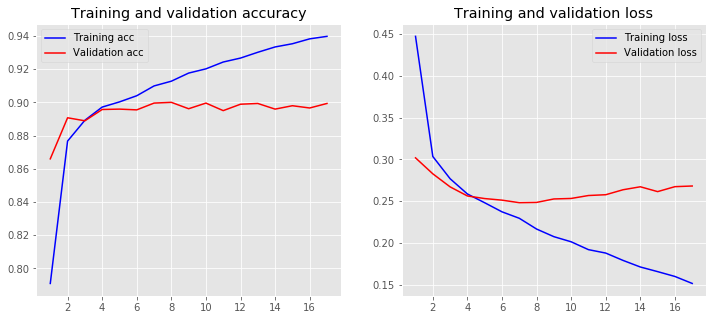

In [28]:
plot_history(history)